## **PROCESS MINING PROJECT FROM A MEDICAL CENTRE**

*The DataSet is composed of data from patients attending a medical centre. There is information about the patient and the actions they have taken since they entered the centre, as well as information about the date and the doctors or nurses involved in each process.*

*The objective is to apply Process Mining with the PM4PY library to analyse processes and find opportunities for improvement (Higher Efficiency).*

In [1]:
import pandas as pd
import pm4py
import matplotlib.pyplot as plt
import seaborn as sns

/tmp/ipykernel_1971/3772108217.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('data/ArtificialPatientTreatment.csv')
df.columns = ['patient', 'action', 'resource', 'datetime']
df['datetime'] = pd.to_datetime(df['datetime'])

df.head()

,patient,action,resource,datetime
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11
1,patient 0,Blood test,Lab,2017-01-02 12:47:33
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09


In [3]:
df['patient'].nunique()

100

In [4]:
df.groupby('action', as_index=False)['patient'].count()

,action,patient
0,Blood test,100
1,Final consult,100
2,First consult,100
3,Medicine,80
4,Physical test,100
5,Second consult,100
6,Surgery,20
7,X-ray scan,90


We can see how all patients have a first consult, a second consult, a final consult, a physical test and a blood test

- Let's use a Heat Map to see it graphically

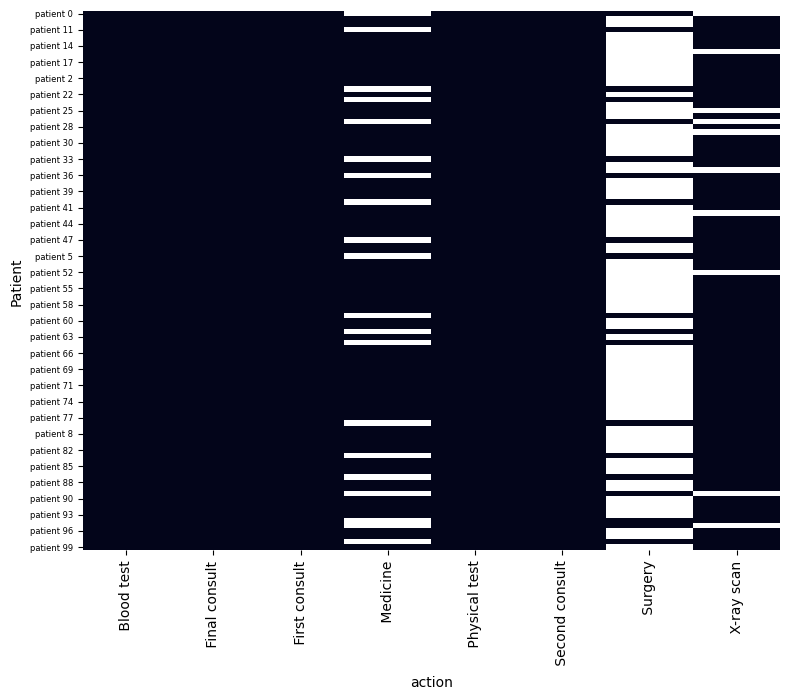

In [5]:
plt.figure(figsize=(9, 7))

sns.heatmap(df.groupby(['patient', 'action']).size().unstack(), cbar=False)
#size() counts the number of observations for each unique combination of 'patient' and 'action'
#unstack converts the index into a column structure

plt.xlabel("action", fontsize=10)
plt.ylabel("Patient", fontsize=10)
plt.yticks(fontsize=6)
plt.show()

In [6]:
num_action = df.groupby('patient', as_index=False)['action'].count()
num_action

,patient,action
0,patient 0,6
1,patient 1,7
2,patient 10,7
3,patient 11,7
4,patient 12,7
...,...,...
95,patient 95,6
96,patient 96,7
97,patient 97,7
98,patient 98,7


In [7]:
print(num_action.max())
print()
print(num_action.min())

patient    patient 99
action              7
dtype: object

patient    patient 0
action             6
dtype: object


Patients receive a minimum of 6 actions and a maximum of 7

- Let's look at the actions taken by each doctor over time

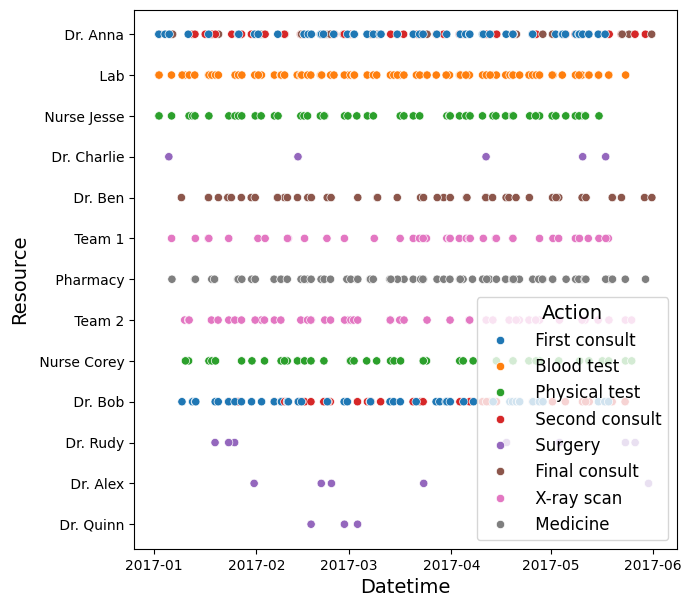

In [8]:
plt.figure(figsize = (7, 7))

sns.scatterplot(x=df['datetime'], y=df['resource'], hue=df['action'])

plt.legend(title='Action', title_fontsize=14, fontsize=12)
plt.xlabel('Datetime', fontsize=14)
plt.ylabel('Resource', fontsize=14)
plt.yticks(fontsize=10)
plt.show()

- Before using pm4py it is necessary to convert the DataFrame into a log

In [9]:
df.head(1)

,patient,action,resource,datetime
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11


In [10]:
from pm4py.objects.conversion.log import converter as log_converter

eventlog = df[["datetime", "patient", "action", "resource"]].copy() #selection of relevant columns
eventlog.sort_values(["patient", "datetime"], inplace=True) #sort by patient and date

#the case_id column is renamed to case:concept:name
#the activity column is renamed to concept:name
#the timestamp column is renamed to time:timestamp
#resource is renamed to org:resource
eventlog.rename(columns={'datetime': 'time:timestamp', 'patient': 'case:concept:name', 'action': 'concept:name', 'resource': 'org:resource'}, inplace=True)

log = log_converter.apply(eventlog)

In [11]:
log

[{'attributes': {'concept:name': 'patient 0'}, 'events': [{'time:timestamp': Timestamp('2017-01-02 11:40:11'), 'concept:name': ' First consult', 'org:resource': ' Dr. Anna'}, '..', {'time:timestamp': Timestamp('2017-01-09 08:29:28'), 'concept:name': ' Final consult', 'org:resource': ' Dr. Ben'}]}, '....', {'attributes': {'concept:name': 'patient 99'}, 'events': [{'time:timestamp': Timestamp('2017-05-18 11:57:11'), 'concept:name': ' First consult', 'org:resource': ' Dr. Bob'}, '..', {'time:timestamp': Timestamp('2017-05-31 12:46:43'), 'concept:name': ' Final consult', 'org:resource': ' Dr. Anna'}]}]

**There are two types of graphs**

- DFG (Directed-Follows Graphs)
    
    The DFG graph represents the direct sequential relationship between activities in a process. Each node in the graph represents an action or activity, and the edges indicate the direct sequential relationship between them.
    
    It allows visualising the sequence of activities and discovering flow patterns in the process. It identifies the most common transitions and helps to understand the basic structure of the process.

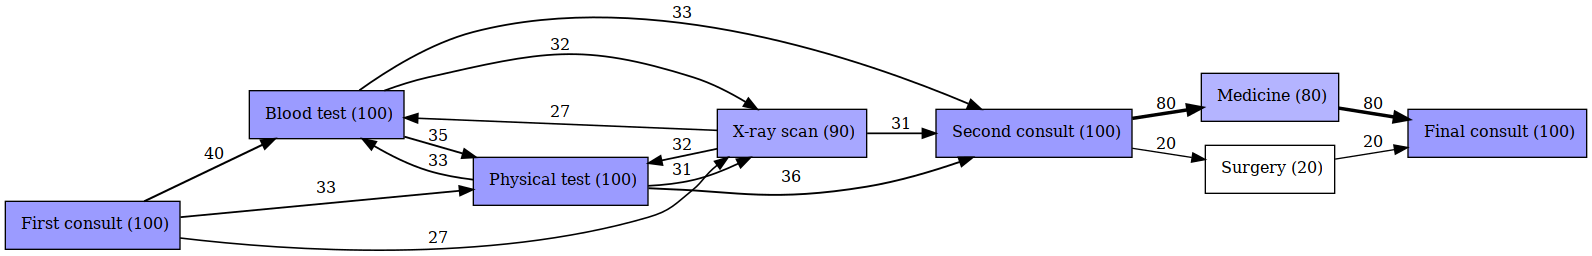

In [12]:
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualization

dfg = dfg_discovery.apply(log)
gviz = dfg_visualization.apply(dfg, log=log, variant=dfg_visualization.Variants.FREQUENCY)
#FREQUENCY, PERCENTAGE, FREQUENCY_AND_PERCENTAGE, PERCENTAGE_INVOLVEMENT
dfg_visualization.view(gviz)

We can see how the **most common sequence** of activities is:

First consult --> blood test --> physical test --> second consult --> medicine --> final consult.

- HM (Heuristic Miner)

    Finds rules that events follow. This approach is useful when data does not strictly comply with a predefined sequence and can adapt to variations and deviations in the process flow. It provides a more flexible and tolerant view of irregularities in the data.

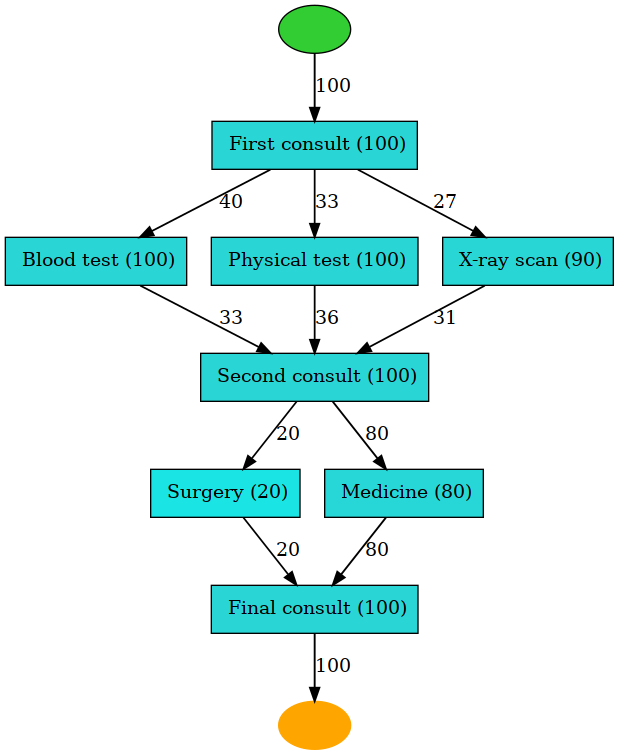

In [13]:
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner

heu_net = heuristics_miner.apply_heu(log)
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

We can see that the activities that do **not follow a strict sequence** are:

On the one hand:  blood test, physical test and x-ray scan.

On the other hand: surgery and medicine.

### How Many Variants The Process Has and What They Are

In [14]:
from pm4py.statistics.variants.log.get import get_variants

variants = get_variants(log)

len(variants)

15

In [15]:
from pm4py.statistics.traces.generic.log import case_statistics

variants_count = case_statistics.get_variant_statistics(log)
variants_count = sorted(variants_count, key=lambda x: x['count'], reverse=True) #is sorted according to the frequency of the variants in descending order

variants_count

[{'variant': (' First consult',
   ' Blood test',
   ' X-ray scan',
   ' Physical test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 18},
 {'variant': (' First consult',
   ' Blood test',
   ' Physical test',
   ' X-ray scan',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 14},
 {'variant': (' First consult',
   ' X-ray scan',
   ' Physical test',
   ' Blood test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 12},
 {'variant': (' First consult',
   ' Physical test',
   ' X-ray scan',
   ' Blood test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 11},
 {'variant': (' First consult',
   ' Physical test',
   ' Blood test',
   ' X-ray scan',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 10},
 {'variant': (' First consult',
   ' X-ray scan',
   ' Blood test',
   ' Physical test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 9},
 {'variant'

-----------------------